In [51]:
import re
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from statistics import mode
from xgboost import XGBClassifier


In [52]:
df = pd.read_csv("../input/h-1b-visa/h1b_kaggle.csv")

In [53]:
df.rename(columns = {'Unnamed: 0' : 'CASE_ID'}, inplace = True)
df.info()
df.head(4)
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002458 entries, 0 to 3002457
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   CASE_ID             int64  
 1   CASE_STATUS         object 
 2   EMPLOYER_NAME       object 
 3   SOC_NAME            object 
 4   JOB_TITLE           object 
 5   FULL_TIME_POSITION  object 
 6   PREVAILING_WAGE     float64
 7   YEAR                float64
 8   WORKSITE            object 
 9   lon                 float64
 10  lat                 float64
dtypes: float64(4), int64(1), object(6)
memory usage: 252.0+ MB


,CASE_ID,PREVAILING_WAGE,YEAR,lon,lat
count,3.002458e+06,3.002373e+06,3.002445e+06,2.895216e+06,2.895216e+06
mean,1.501230e+06,1.469984e+05,2.013855e+03,-9.213441e+01,3.816054e+01
std,8.667351e+05,5.287609e+06,1.680612e+00,1.965591e+01,4.672835e+00
min,1.000000e+00,0.000000e+00,2.011000e+03,-1.578583e+02,1.343719e+01
25%,7.506152e+05,5.437100e+04,2.012000e+03,-1.119261e+02,3.416536e+01
50%,1.501230e+06,6.502100e+04,2.014000e+03,-8.615862e+01,3.910312e+01
75%,2.251844e+06,8.143200e+04,2.015000e+03,-7.551381e+01,4.088374e+01
max,3.002458e+06,6.997607e+09,2.016000e+03,1.457298e+02,6.483778e+01


In [54]:
# Case status is the target variable, remaining all columns are independent.
df['CASE_STATUS'].unique()

array(['CERTIFIED-WITHDRAWN', 'WITHDRAWN', 'CERTIFIED', 'DENIED',
       'REJECTED', 'INVALIDATED',
       'PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED', nan],
      dtype=object)

In [55]:
import warnings
warnings.filterwarnings("ignore")
# Classifying the data set into a binary model. Rejected, Invalidated, Pending are labelled as denied!
df.CASE_STATUS[df['CASE_STATUS']=='REJECTED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='INVALIDATED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='CERTIFIED-WITHDRAWN'] = 'CERTIFIED'

In [56]:
##Drop rows with withdrawn
df.EMPLOYER_NAME.describe()
df = df.drop(df[df.CASE_STATUS == 'WITHDRAWN'].index)

In [57]:
df = df[df['CASE_STATUS'].notnull()]
print(df['CASE_STATUS'].value_counts())

CERTIFIED    2818282
DENIED         94364
Name: CASE_STATUS, dtype: int64


In [58]:
print(94364/(94364 + 2818282))
# Only 3.23% percent applications are denied as per this dataser. So this is heavily biased towards Certified.

0.032398032579311044


In [59]:
count_nan = len(df) - df.count()
print(count_nan)

CASE_ID                    0
CASE_STATUS                0
EMPLOYER_NAME             18
SOC_NAME               17073
JOB_TITLE                 10
FULL_TIME_POSITION         1
PREVAILING_WAGE           53
YEAR                       0
WORKSITE                   0
lon                   102844
lat                   102844
dtype: int64


In [60]:
# The 18 missing values of employers can be replaced with most frequent employers
df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].fillna(df['EMPLOYER_NAME'].mode()[0])

In [61]:
assert pd.notnull(df['EMPLOYER_NAME']).all().all()

In [62]:
print(np.nanpercentile(df.PREVAILING_WAGE,98))
df.PREVAILING_WAGE.median()
# Finding the outliers in the wages. 

138611.0


65000.0

In [63]:
df.loc[df.PREVAILING_WAGE < 34029, 'PREVAILING_WAGE']= 34029
df.loc[df['PREVAILING_WAGE'] > 138611, 'PREVAILING_WAGE']= 138611
df.PREVAILING_WAGE.fillna(df.PREVAILING_WAGE.mean(), inplace = True)
# Replacing the outliers of top 2 and 98th percentiles with median and top.

In [64]:
df['JOB_TITLE'] = df['JOB_TITLE'].fillna(df['JOB_TITLE'].mode()[0])
df['FULL_TIME_POSITION'] = df['FULL_TIME_POSITION'].fillna(df['FULL_TIME_POSITION'].mode()[0])
df['SOC_NAME'] = df['SOC_NAME'].fillna(df['SOC_NAME'].mode()[0])
# Filling all the missing values with mode.

In [65]:
foo1 = df['FULL_TIME_POSITION']=='Y'
foo2 = df['CASE_STATUS']=='CERIFIED'
print(len(df[foo1])/len(df))
# Two different ways to calculate full time jobs. Around 85% jobs are FULL TIME.
fooy = df.FULL_TIME_POSITION[df['FULL_TIME_POSITION']=='Y'].count()
foox = df.CASE_STATUS[df['CASE_STATUS']=='CERIFIED'].count()
print(fooy/df.FULL_TIME_POSITION.count())

0.8587040786968275
0.8587040786968275


In [66]:
# Dropping lat and lon columns
df = df.drop('lat', axis = 1)
df = df.drop('lon', axis = 1)

In [67]:
# University applications has definite chances of approval than a normal IT Employer.
# creating new_employer column to bring universities into that list from employers column
df['NEW_EMPLOYER'] = np.nan
df.shape

(2912646, 10)

In [68]:
# Converting the strings to lower case and match with 'university' to bring those values to new_employer
df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].str.lower()
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('university')] = 'university'
df['NEW_EMPLOYER']= df.NEW_EMPLOYER.replace(np.nan, 'non university', regex=True)

In [69]:
# Creating occupation and mapping the values
warnings.filterwarnings("ignore")

df['OCCUPATION'] = np.nan
df['SOC_NAME'] = df['SOC_NAME'].str.lower()
df.OCCUPATION[df['SOC_NAME'].str.contains('computer','programmer')] = 'computer occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('software','web developer')] = 'computer occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('database')] = 'computer occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('math','statistic')] = 'Mathematical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('predictive model','stats')] = 'Mathematical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('teacher','linguist')] = 'Education Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('professor','Teach')] = 'Education Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('school principal')] = 'Education Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('medical','doctor')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('physician','dentist')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('Health','Physical Therapists')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('surgeon','nurse')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('psychiatr')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('chemist','physicist')] = 'Advance Sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('biology','scientist')] = 'Advance Sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('biologi','clinical research')] = 'Advance Sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('public relation','manage')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('management','operation')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('chief','plan')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('executive')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('advertis','marketing')] = 'Marketing Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('promotion','market research')] = 'Marketing Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('business','business analyst')] = 'Business Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('business systems analyst')] = 'Business Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('accountant','finance')] = 'Financial Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('financial')] = 'Financial Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('engineer','architect')] = 'Architecture & Engineering'
df.OCCUPATION[df['SOC_NAME'].str.contains('surveyor','carto')] = 'Architecture & Engineering'
df.OCCUPATION[df['SOC_NAME'].str.contains('technician','drafter')] = 'Architecture & Engineering'
df.OCCUPATION[df['SOC_NAME'].str.contains('information security','information tech')] = 'Architecture & Engineering'
df['OCCUPATION']= df.OCCUPATION.replace(np.nan, 'Others', regex=True)

In [70]:
## Splitting city and state and capturing state in another variable
df['state'] = df.WORKSITE.str.split('\s+').str[-1]

In [71]:
print(df.head())

   CASE_ID CASE_STATUS                                      EMPLOYER_NAME  \
0        1   CERTIFIED                             university of michigan   
1        2   CERTIFIED                             goodman networks, inc.   
2        3   CERTIFIED                          ports america group, inc.   
3        4   CERTIFIED  gates corporation, a wholly-owned subsidiary o...   
5        6   CERTIFIED                            burger king corporation   

                        SOC_NAME  \
0  biochemists and biophysicists   
1               chief executives   
2               chief executives   
3               chief executives   
5               chief executives   

                                           JOB_TITLE FULL_TIME_POSITION  \
0                       POSTDOCTORAL RESEARCH FELLOW                  N   
1                            CHIEF OPERATING OFFICER                  Y   
2                              CHIEF PROCESS OFFICER                  Y   
3                   

In [72]:
# Now in order to calculate probabilities we need to convert case_status certified and denied to binary values 0,1.
from sklearn import preprocessing
class_mapping = {'CERTIFIED':0, 'DENIED':1}
df["CASE_STATUS"] = df["CASE_STATUS"].map(class_mapping)

In [73]:
print(df.head())

   CASE_ID  CASE_STATUS                                      EMPLOYER_NAME  \
0        1            0                             university of michigan   
1        2            0                             goodman networks, inc.   
2        3            0                          ports america group, inc.   
3        4            0  gates corporation, a wholly-owned subsidiary o...   
5        6            0                            burger king corporation   

                        SOC_NAME  \
0  biochemists and biophysicists   
1               chief executives   
2               chief executives   
3               chief executives   
5               chief executives   

                                           JOB_TITLE FULL_TIME_POSITION  \
0                       POSTDOCTORAL RESEARCH FELLOW                  N   
1                            CHIEF OPERATING OFFICER                  Y   
2                              CHIEF PROCESS OFFICER                  Y   
3             

In [74]:
test1 = pd.Series(df['JOB_TITLE'].ravel()).unique()
print(pd.DataFrame(test1))
# we have 284549 unique job titles!!

                                                        0
0                            POSTDOCTORAL RESEARCH FELLOW
1                                 CHIEF OPERATING OFFICER
2                                   CHIEF PROCESS OFFICER
3                             REGIONAL PRESIDEN, AMERICAS
4       EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...
...                                                   ...
284544                              DFT MODELING ENGINEER
284545      SENIOR SOFTWARE ENGINEER (LTE PROTOCOL STACK)
284546                       CHEMISTRY  - SCIENCE TEACHER
284547                         SALES AND LOGISTIC MANAGER
284548                            APPRAISERS, REAL ESTATE

[284549 rows x 1 columns]


In [75]:
# dropping these columns unnecessary
df = df.drop('EMPLOYER_NAME', axis = 1)
df = df.drop('SOC_NAME', axis = 1)
df = df.drop('JOB_TITLE', axis = 1)
df = df.drop('WORKSITE', axis = 1)
df = df.drop('CASE_ID', axis = 1)

In [76]:
df1 = df.copy()

In [77]:
# Changing the data types from objects to category as these are categorical features.
df1[['CASE_STATUS', 'FULL_TIME_POSITION', 'YEAR','NEW_EMPLOYER','OCCUPATION','state']] = df1[['CASE_STATUS', 'FULL_TIME_POSITION', 'YEAR','NEW_EMPLOYER','OCCUPATION','state']].apply(lambda x: x.astype('category'))

In [78]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2912646 entries, 0 to 3002392
Data columns (total 7 columns):
 #   Column              Dtype   
---  ------              -----   
 0   CASE_STATUS         category
 1   FULL_TIME_POSITION  category
 2   PREVAILING_WAGE     float64 
 3   YEAR                category
 4   NEW_EMPLOYER        category
 5   OCCUPATION          category
 6   state               category
dtypes: category(6), float64(1)
memory usage: 61.1 MB


In [79]:
#Splitting Data in Training and Test Sets:
#It's a standard practice to split the dataset into a training and testing set. 
#The reason behind this is that you should fit and train your model using the training set, 
# and then finally predict and check your accuracy on the test set.

X = df.drop('CASE_STATUS', axis=1)
y = df.CASE_STATUS

seed = 7
test_size = 0.40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
X_train.columns



Index(['FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR', 'NEW_EMPLOYER',
       'OCCUPATION', 'state'],
      dtype='object')

In [80]:
# Checking for null values in training set
print(X_train.isnull().sum())

FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
NEW_EMPLOYER          0
OCCUPATION            0
state                 0
dtype: int64


In [81]:
X_train_encode = pd.get_dummies(X_train)
X_test_encode = pd.get_dummies(X_test)

In [82]:
y_train.head()

1005328    0
816196     0
1582854    0
825095     0
2963078    0
Name: CASE_STATUS, dtype: int64

In [83]:
train_X = X_train_encode.to_numpy()
train_y = y_train.to_numpy()

In [84]:
import xgboost
gbm=xgboost.XGBClassifier(max_features='sqrt', subsample=0.8, random_state=10)

In [85]:
from sklearn.model_selection import GridSearchCV

In [86]:
parameters = [{'n_estimators': [10, 100]},
              {'learning_rate': [0.1, 0.01, 0.5]}]

In [87]:
grid_search = GridSearchCV(estimator = gbm, param_grid = parameters, scoring='accuracy', cv = 3, n_jobs=-1)

In [88]:
grid_search = grid_search.fit(train_X, train_y)

[01:48:06] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [91]:
grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_

({'mean_fit_time': array([ 85.58294145, 755.23643327, 766.31867687, 768.37178254,
         746.54448485]),
  'std_fit_time': array([0.46522982, 2.36963867, 0.9613996 , 2.20184403, 3.36898187]),
  'mean_score_time': array([2.17970085, 5.45348446, 5.11083229, 4.78138614, 4.54338757]),
  'std_score_time': array([0.11042936, 0.07986435, 0.14571532, 0.00406283, 0.06282171]),
  'param_n_estimators': masked_array(data=[10, 100, --, --, --],
               mask=[False, False,  True,  True,  True],
         fill_value='?',
              dtype=object),
  'param_learning_rate': masked_array(data=[--, --, 0.1, 0.01, 0.5],
               mask=[ True,  True, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 10},
   {'n_estimators': 100},
   {'learning_rate': 0.1},
   {'learning_rate': 0.01},
   {'learning_rate': 0.5}],
  'split0_test_score': array([0.96769775, 0.96774238, 0.96774066, 0.96772865, 0.96765483]),
  'split1_test_score': array([0.967

In [92]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              max_features='sqrt', min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=10, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [93]:
gbm=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=3, max_features='sqrt', min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=10, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8).fit(train_X, train_y)

[01:55:18] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [95]:
y_pred = gbm.predict(X_test_encode.to_numpy())
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
#The Overall accuracy of the model is 96.56% 
# with Certified having a precision of 97% and Denied with a precision of 56%. 

[[1126962     190]
 [  37708     199]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98   1127152
           1       0.51      0.01      0.01     37907

    accuracy                           0.97   1165059
   macro avg       0.74      0.50      0.50   1165059
weighted avg       0.95      0.97      0.95   1165059



In [96]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.5025405617954232

0.5025405617954232


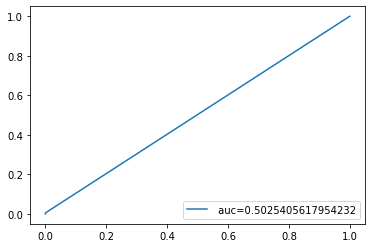

In [97]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr_xg, tpr_xg, thresholds = metrics.roc_curve(y_test, y_pred)
print(metrics.auc(fpr_xg, tpr_xg))
auc_xgb = np.trapz(tpr_xg,fpr_xg)
plt.plot(fpr_xg,tpr_xg,label=" auc="+str(auc_xgb))
plt.legend(loc=4)
plt.show()